In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


In [ ]:

uploaded = files.upload()




Saving btc2.csv to btc2.csv


In [ ]:
btc =pd.read_csv("btc2.csv",delimiter=",")
print(btc.tail())

     ticker        date     open     high      low    close
5341    BTC  2025-04-18  85045.5  85123.6  84304.0  84630.0
5342    BTC  2025-04-19  84634.5  85621.5  84361.6  85339.5
5343    BTC  2025-04-20  85339.5  85346.7  83960.2  84981.0
5344    BTC  2025-04-21  84981.5  88474.8  84677.1  87283.7
5345    BTC  2025-04-22  87283.7  93491.1  86928.7  93055.5



Test Metrics (XGBoost on Returns):
  RMSE: 0.028217
  MAE : 0.021181
  R²  : -0.2971


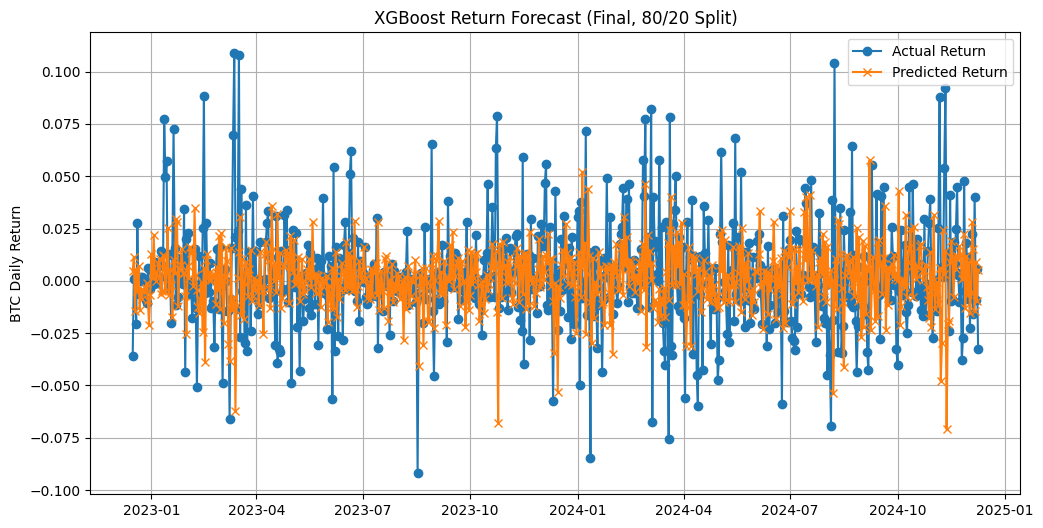

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
btc = pd.read_csv("btc2.csv")
btc['date'] = pd.to_datetime(btc['date'])
btc = btc.sort_values('date')
btc = btc[(btc['date'] >= '2015-01-01') & (btc['date'] <= '2025-01-01')]

btc.set_index('date', inplace=True)
btc['return'] = btc['close'].pct_change()
btc.dropna(inplace=True)
LAGS = 5

for lag in range(1, LAGS + 1):
    btc[f'lag_{lag}'] = btc['return'].shift(lag)

btc.dropna(inplace=True)
split_point = int(len(btc) * 0.8)
train = btc.iloc[:split_point]
test = btc.iloc[split_point:]

X_train = train[[f'lag_{lag}' for lag in range(1, LAGS + 1)]]
y_train = train['return']

X_test = test[[f'lag_{lag}' for lag in range(1, LAGS + 1)]]
y_test = test['return']
model = XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print("\nTest Metrics (XGBoost on Returns):")
print(f"  RMSE: {rmse:.6f}")
print(f"  MAE : {mae:.6f}")
print(f"  R²  : {r2:.4f}")

# ---- 7. Plot ---- #
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Actual Return', marker='o')
plt.plot(y_test.index, y_test_pred, label='Predicted Return', marker='x')
plt.title("XGBoost Return Forecast (Final, 80/20 Split)")
plt.ylabel("BTC Daily Return")
plt.grid()
plt.legend()
plt.show()



Test Metrics (XGBoost on Log Returns):
  RMSE: 0.028244
  MAE : 0.020956
  R²  : -0.3210


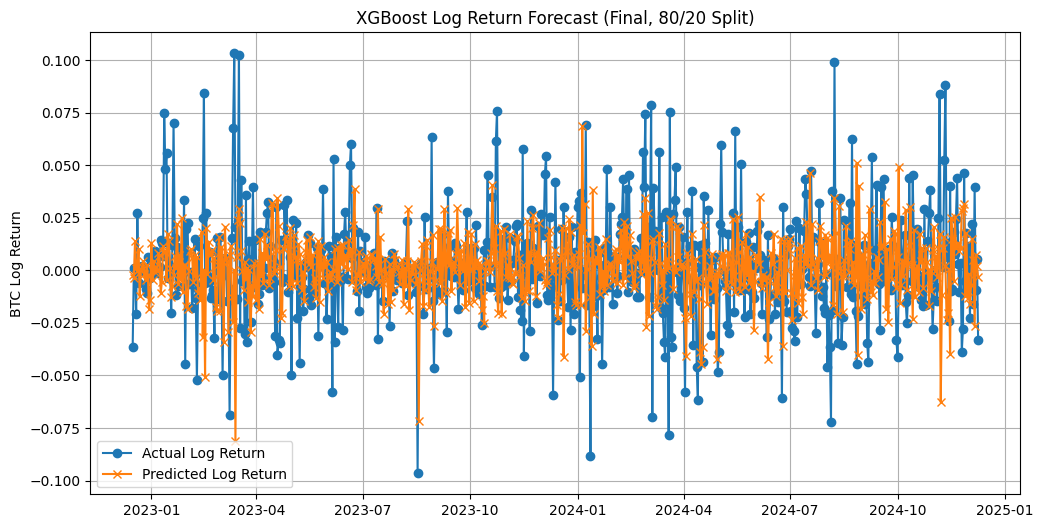

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

# ---- 1. Load and prepare data ---- #
btc = pd.read_csv("btc2.csv")
btc['date'] = pd.to_datetime(btc['date'])
btc = btc.sort_values('date')
btc = btc[(btc['date'] >= '2015-01-01') & (btc['date'] <= '2025-01-01')]

btc.set_index('date', inplace=True)


# ---- 2. Compute log returns ---- #
btc['log_return'] = np.log(btc['close'] / btc['close'].shift(1))
btc.dropna(inplace=True)

# ---- 3. Create lagged log return features ---- #
LAGS = 5  # Number of lag days to use as features

for lag in range(1, LAGS + 1):
    btc[f'lag_{lag}'] = btc['log_return'].shift(lag)

btc.dropna(inplace=True)  # Drop rows with NaNs from lags

# ---- 4. Train-test split (80/20) ---- #
split_point = int(len(btc) * 0.8)
train = btc.iloc[:split_point]
test = btc.iloc[split_point:]

X_train = train[[f'lag_{lag}' for lag in range(1, LAGS + 1)]]
y_train = train['log_return']

X_test = test[[f'lag_{lag}' for lag in range(1, LAGS + 1)]]
y_test = test['log_return']

# ---- 5. Train XGBoost model ---- #
model = XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

# ---- 6. Predict and evaluate ---- #
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print("\nTest Metrics (XGBoost on Log Returns):")
print(f"  RMSE: {rmse:.6f}")
print(f"  MAE : {mae:.6f}")
print(f"  R²  : {r2:.4f}")

# ---- 7. Plot ---- #
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Actual Log Return', marker='o')
plt.plot(y_test.index, y_test_pred, label='Predicted Log Return', marker='x')
plt.title("XGBoost Log Return Forecast (Final, 80/20 Split)")
plt.ylabel("BTC Log Return")
plt.grid()
plt.legend()
plt.show()
